# Training of model with just municipalities

In [1]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
import tqdm
from math import sqrt

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

df = pd.read_csv('Boliga - Final for training.csv')
df = df.drop(columns = ['Relativ Ledighed', 'Grundskole', 'Gymnasiale uddannelser', 
                       'Erhvervsfaglige uddannelser', 'KVU', 'MVU', 'Bacheloruddannelser',
                        'Kommunal_gennemsnitsinkomst_2017', 'Total_reported', ' LVU',
                       'Population_in_urban_development', 'Socioeconomic_index',
                       'expenses_per_school_student', 'average_class_size', 'expenses_sport_and_other_cultural_activities'])

df_sample = df.sample(1000)

In [2]:
pd.options.display.max_columns = None

### Create dummies, and split X and Y

In [3]:
df_dum = pd.get_dummies(df_sample, drop_first = True, columns = ['isForeclosure', 'Kommune', 'Type'])
X = df_dum.drop(columns = ['price'])
y = df_dum['price']

### Split into test, dev, val and train data

In [4]:
from sklearn.model_selection import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.5, random_state = 1)

### Linear Regression Model

First, we train (fit) a linear regression on the development (in this case the **training**) data, as it does not need validation (no hyperparameter needs to be optimized)

In [5]:
#Create pipeline (pipe_lr which will be used later, to compare Lasso and LR)
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=True, degree = 2), 
                        StandardScaler(with_mean = 0, with_std = True),
                        LinearRegression())

#Fit pipline to dev-data
pipe_lr.fit(X_dev, y_dev)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=0, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### OLS (linear regression) estimations table

Find a way to get the OLS estimates out here, in a table

## Train Lasso Regression (K-fold CV)

Now we want to examine whether the a Lasso regression is more appropriate, and seeks to optimize the hyperparameter.
We will train for an optimized hyperparameter on the validation set, to avoid data leakage and use k-fold crossvalidation to make sure that we have not split our dataset in a lucky or unlucky place. 

In [6]:
from sklearn.model_selection import KFold

#Split data into 5 folds
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))

#Create Lambda values
lambdas = np.logspace(-4, 4, 12)
# outer loop: lambdas
mseCV = []
rmseCV = []
maeCV = []
for lambda_ in tqdm.tqdm(lambdas):    
    # inner loop: folds
    mseCV_ = []
    rmseCV_ = []
    maeCV_ = []
    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=3, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))
        rmseCV_.append(sqrt(mse(pipe_lassoCV.predict(X_val), y_val)))
        maeCV_.append(mae(pipe_lassoCV.predict(X_val), y_val))
        
        
    # store result    
    mseCV.append(mseCV_) 
    rmseCV.append(rmseCV_)
    maeCV.append(maeCV_)
    
# convert to DataFrame
lambda_mseCV = pd.DataFrame(mseCV, index=lambdas)
lambda_rmseCV = pd.DataFrame(rmseCV, index=lambdas)
lambda_maeCV = pd.DataFrame(maeCV, index=lambdas)

 58%|█████▊    | 7/12 [20:45<14:45, 177.15s/it]/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not con

### MSE of the K-fold Crossvalidation

Lambda as index

In [8]:
lambda_mseCV

,0,1,2,3,4
0.000100,6.473383e+18,8.375524e+14,1.969650e+13,1.244208e+14,1.100649e+13
0.000534,6.473372e+18,8.375147e+14,1.969656e+13,1.244212e+14,1.100619e+13
0.002848,6.473315e+18,8.373141e+14,1.969686e+13,1.244257e+14,1.100464e+13
0.015199,6.473014e+18,8.362374e+14,1.969742e+13,1.244814e+14,1.099791e+13
0.081113,6.470870e+18,8.305869e+14,1.969646e+13,1.252318e+14,1.095613e+13
0.432876,6.459015e+18,8.042178e+14,1.970370e+13,1.356365e+14,1.069999e+13
2.310130,6.453043e+18,6.308086e+14,1.953709e+13,1.371302e+14,1.004944e+13
12.328467,5.575684e+18,2.040237e+14,2.367632e+13,2.087746e+13,7.976833e+12
65.793322,3.960765e+18,6.417637e+12,2.054052e+13,2.840084e+13,9.466334e+12
351.119173,1.224247e+17,1.353474e+13,1.487161e+13,9.320214e+12,4.516251e+12


In [9]:
# Calculates the mean of the folds
mse_mean = lambda_mseCV.mean(axis = 1)
rmse_mean = lambda_rmseCV.mean(axis = 1)
mae_mean = lambda_maeCV.mean(axis = 1)

[Text(0,0.5,'MSE'), Text(0.5,0,'Lambda')]

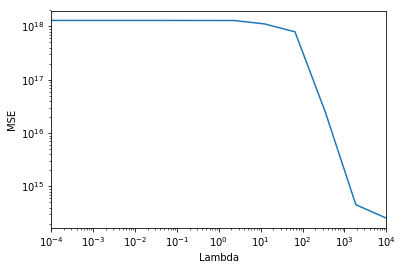

In [11]:
#Plot mean square errors
COL = ['Average MSE']
mse_mean.columns = COL

#Both axis are logarythmical 
ax = mse_mean.plot(logx = True, logy = True)
ax.set(xlabel = 'Lambda', ylabel = 'MSE')


In [ ]:
# Vi udvider range til højere

In [21]:
round(mse_mean,1)



0.000100        1.294875e+18
0.000534        1.294873e+18
0.002848        1.294862e+18
0.015199        1.294801e+18
0.081113        1.294371e+18
0.432876        1.291997e+18
2.310130        1.290768e+18
12.328467       1.115188e+18
65.793322       7.921660e+17
351.119173      2.449339e+16
1873.817423     4.538124e+14
10000.000000    2.544970e+14
dtype: float64

In [19]:

round(rmse_mean,1)


0.000100        518426983.3
0.000534        518426435.0
0.002848        518423500.7
0.015199        518408257.0
0.081113        518309843.7
0.432876        517834849.0
2.310130        516940055.1
12.328467       477566316.7
65.793322       401127723.7
351.119173       72521160.4
1873.817423      15696406.1
10000.000000     12127309.2
dtype: float64

In [15]:

round(mae_mean, 2)

0.000100        44978875.41
0.000534        44978478.35
0.002848        44976355.76
0.015199        44965119.81
0.081113        44913395.15
0.432876        44692538.15
2.310130        43565262.50
12.328467       40130702.99
65.793322       33349510.72
351.119173       7260417.78
1873.817423      2547847.13
10000.000000     1974993.60
dtype: float64

### Finding the optimal hyperparameter

In [ ]:
mse_mean.nsmallest(1)

# Comparison of Lasso and Linear Regression

Is done after the optimized hyperparameters is found (after training on validation data)
This comparison is done on the **test data!** and is thus the final step in training and selecting our model


In [25]:
# Optimal lambda is inserted into the Lasso-model
optimal_lambda = lambda_mseCV.mean(axis=1).nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=1))
pipe_lassoCV.fit(X_dev,y_dev)

# compare performance by mse
models = {'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    score_mse = mse(model.predict(X_test),y_test)
    score_mae = mae(model.predict(X_test),y_test)
    score_rmse = sqrt(mse(model.predict(X_test),y_test))
    
    print("MSE: " + name, round(score_mse, 2))
    print("RMSE: " + name, round(score_rmse, 2))
    print("MAE: " + name, round(score_mae, 2))

MSE: Lasso CV 1086176175864.48
RMSE: Lasso CV 1042197.76
MAE: Lasso CV 690907.1
MSE: LinReg 390929707520338.25
RMSE: LinReg 19771942.43
MAE: LinReg 11224727.52


## Subconclusion

The model is too complex and very unable to predict out-of-sample data. 
Though the Lasso is a great imporvement to the simple linear regression, it still produces error in the realm of trillions. 
Consider making a more simple model instead

## Error Table

We calculate the Mean Absolute Error, Mean Squared Error and Root Mean Squard Errors of the differnet models: OLS (Linear Regression), Lasso, Ridge.

## Correlation plot

In [ ]:
corr = df_dum.corr()
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);